In [1]:
#Импорты библиотек
import pandas as pd
import numpy  as np
from sklearn.model_selection import train_test_split
#import seaborn as sns
import matplotlib.pyplot as plt

import warnings
import torch
import sklearn
import stumpy

from tqdm import tqdm
from scipy.optimize import minimize
from sklearn.model_selection import TimeSeriesSplit
from matplotlib.patches import Rectangle

from func import analize_df, replace_outliers, find_outliers, popular_tok

warnings.filterwarnings('ignore')

In [2]:
#Загрузить датасет в Python.

df = pd.read_csv('bitcoin_2017_to_2023.csv',sep=',')

df.head()

,timestamp,open,high,low,close,volume,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume
0,2023-08-01 13:19:00,28902.48,28902.49,28902.48,28902.49,4.68658,1.354538e+05,258,0.89391,25836.224836
1,2023-08-01 13:18:00,28902.48,28902.49,28902.48,28902.49,4.77589,1.380351e+05,317,2.24546,64899.385195
2,2023-08-01 13:17:00,28908.52,28908.53,28902.48,28902.49,11.52263,3.330532e+05,451,2.70873,78290.170121
3,2023-08-01 13:16:00,28907.41,28912.74,28907.41,28908.53,15.89610,4.595556e+05,483,10.22981,295738.166916
4,2023-08-01 13:15:00,28896.00,28907.42,28893.03,28907.41,37.74657,1.090761e+06,686,16.50452,476955.246611


In [3]:
#сразу выкидывем дубли
df=df.drop_duplicates()

In [4]:
analize_df(df)
df.head(10)

dtypes
timestamp                        object
open                            float64
high                            float64
low                             float64
close                           float64
volume                          float64
quote_asset_volume              float64
number_of_trades                  int64
taker_buy_base_asset_volume     float64
taker_buy_quote_asset_volume    float64
dtype: object
shape
(3123928, 10)
isnull
timestamp                       0
open                            0
high                            0
low                             0
close                           0
volume                          0
quote_asset_volume              0
number_of_trades                0
taker_buy_base_asset_volume     0
taker_buy_quote_asset_volume    0
dtype: int64
value_counts



timestamp 3123928 !!!!!!!!!!!!!!!!!!!!!!/
timestamp
2023-08-01 13:19:00    1
2019-08-14 03:28:00    1
2019-08-14 03:37:00    1
2019-08-14 03:36:00    1
2019-08-14 03:35:00    1
      

,timestamp,open,high,low,close,volume,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume
0,2023-08-01 13:19:00,28902.48,28902.49,28902.48,28902.49,4.68658,1.354538e+05,258,0.89391,25836.224836
1,2023-08-01 13:18:00,28902.48,28902.49,28902.48,28902.49,4.77589,1.380351e+05,317,2.24546,64899.385195
2,2023-08-01 13:17:00,28908.52,28908.53,28902.48,28902.49,11.52263,3.330532e+05,451,2.70873,78290.170121
3,2023-08-01 13:16:00,28907.41,28912.74,28907.41,28908.53,15.89610,4.595556e+05,483,10.22981,295738.166916
4,2023-08-01 13:15:00,28896.00,28907.42,28893.03,28907.41,37.74657,1.090761e+06,686,16.50452,476955.246611
5,2023-08-01 13:14:00,28890.40,28896.00,28890.39,28895.99,9.88869,2.857173e+05,389,5.46417,157873.630690
6,2023-08-01 13:13:00,28889.63,28890.40,28889.63,28890.39,17.87871,5.165159e+05,266,16.19349,467829.891694
7,2023-08-01 13:12:00,28881.54,28889.64,28881.53,28889.64,13.48153,3.894235e+05,500,11.58691,334697.039929
8,2023-08-01 13:11:00,28876.00,28881.54,28875.99,28881.54,6.85924,1.980829e+05,274,5.93315,171339.627576
9,2023-08-01 13:10:00,28872.48,28876.00,28870.00,28876.00,10.75734,3.105872e+05,381,7.87944,227495.165785


In [5]:
#Привожу к формату datetime
df['timestamp_dt']=pd.to_datetime(df['timestamp'])
df['timestamp_dt'].min(), df['timestamp_dt'].max()

(Timestamp('2017-08-17 04:00:00'), Timestamp('2023-08-01 13:19:00'))

In [6]:
#Информаионное поле - сколько времени прошло (больше для того чтобы мне было проще смотреть, 
#но ниже всё-таки использую этот столбец)
df['timestamp_minutes']=((df['timestamp_dt']-df['timestamp_dt'].min()).dt.days*60*24).astype(int)+((df['timestamp_dt']-df['timestamp_dt'].min()).dt.seconds/60).astype(int)#.dt.hour
df.head()

,timestamp,open,high,low,close,volume,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,timestamp_dt,timestamp_minutes
0,2023-08-01 13:19:00,28902.48,28902.49,28902.48,28902.49,4.68658,1.354538e+05,258,0.89391,25836.224836,2023-08-01 13:19:00,3132559
1,2023-08-01 13:18:00,28902.48,28902.49,28902.48,28902.49,4.77589,1.380351e+05,317,2.24546,64899.385195,2023-08-01 13:18:00,3132558
2,2023-08-01 13:17:00,28908.52,28908.53,28902.48,28902.49,11.52263,3.330532e+05,451,2.70873,78290.170121,2023-08-01 13:17:00,3132557
3,2023-08-01 13:16:00,28907.41,28912.74,28907.41,28908.53,15.89610,4.595556e+05,483,10.22981,295738.166916,2023-08-01 13:16:00,3132556
4,2023-08-01 13:15:00,28896.00,28907.42,28893.03,28907.41,37.74657,1.090761e+06,686,16.50452,476955.246611,2023-08-01 13:15:00,3132555


In [7]:
#Сортируем от более старой к более новой
df=df.sort_values(by=['timestamp_dt'])
df=df.reset_index().drop(['index'],axis=1)
df.head()

,timestamp,open,high,low,close,volume,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,timestamp_dt,timestamp_minutes
0,2017-08-17 04:00:00,4261.48,4261.48,4261.48,4261.48,1.775183,7564.906851,3,0.075183,320.390851,2017-08-17 04:00:00,0
1,2017-08-17 04:01:00,4261.48,4261.48,4261.48,4261.48,0.000000,0.000000,0,0.000000,0.000000,2017-08-17 04:01:00,1
2,2017-08-17 04:02:00,4280.56,4280.56,4280.56,4280.56,0.261074,1117.542921,2,0.261074,1117.542921,2017-08-17 04:02:00,2
3,2017-08-17 04:03:00,4261.48,4261.48,4261.48,4261.48,0.012008,51.171852,3,0.012008,51.171852,2017-08-17 04:03:00,3
4,2017-08-17 04:04:00,4261.48,4261.48,4261.48,4261.48,0.140796,599.999338,1,0.140796,599.999338,2017-08-17 04:04:00,4


Text(0.5, 1.0, 'Курс биткоина')

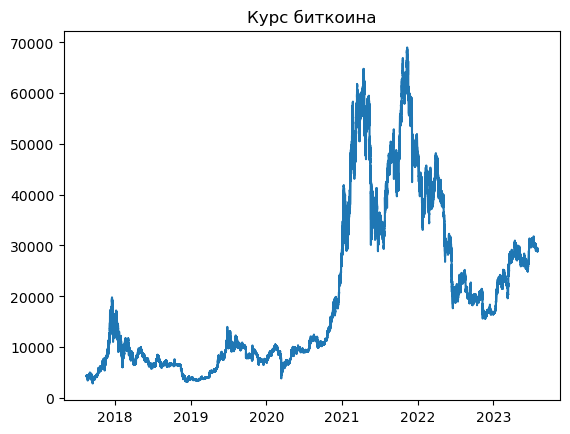

In [8]:
#Рисуем график по датасету
plt.plot(df['timestamp_dt'], df['close'])
plt.title("Курс биткоина")

In [9]:
#Выводим интервалы между этой и следующей датой (по количеству).Видно что они были до конца дотошны
data_gap=df['timestamp_minutes']
data_gap.loc[0]=df['timestamp_minutes'].max()+1
data_gap=data_gap.sort_values()
data_gap=data_gap.reset_index().drop(['index'],axis=1)
data_gap=(data_gap['timestamp_minutes']-df['timestamp_minutes'])
data_gap.value_counts()

timestamp_minutes
 1          3123892
 61               3
 211              2
 121              2
 151              2
 601              2
-3132559          1
 355              1
 4                1
 129              1
 481              1
 253              1
 80               1
 91               1
 285              1
 271              1
 141              1
 361              1
 62               1
 421              1
 458              1
 106              1
 35               1
 16               1
 2012             1
 126              1
 65               1
 14               1
 49               1
 420              1
 81               1
Name: count, dtype: int64

In [10]:
#смотрю когда был разрыв (без какого-то особого смысла, просто понять контекст)
df[data_gap==2012]

,timestamp,open,high,low,close,volume,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,timestamp_dt,timestamp_minutes
251119,2018-02-08 00:28:00,7790.0,7794.91,7783.81,7784.02,8.153564,63515.480816,100,6.604319,51454.167869,2018-02-08 00:28:00,251788


In [11]:
df.loc[251119+1]

timestamp                       2018-02-09 10:00:00
open                                         7789.9
high                                         8290.0
low                                          7789.9
close                                        8290.0
volume                                   210.243307
quote_asset_volume                   1707702.800124
number_of_trades                               1134
taker_buy_base_asset_volume              166.221642
taker_buy_quote_asset_volume         1346912.003258
timestamp_dt                    2018-02-09 10:00:00
timestamp_minutes                            253800
Name: 251120, dtype: object

In [12]:
#координаты разрывов
data_gap_idx = data_gap[lambda x: x!=1].index#[1:]
data_gap_idx

Index([      0,   29520,  156661,  177013,  177149,  200996,  251119,  252319,
        253625,  447870,  449370,  458588,  612548,  649538,  819038,  910898,
        944512, 1042657, 1171777, 1171847, 1188914, 1298234, 1313150, 1332822,
       1407132, 1499142, 1722372, 1753020, 1757820, 1826981, 1859921, 1924631,
       1931802, 2089797, 2157507, 2936767],
      dtype='int64')

In [13]:
#Достаём данные между двух разрывов (весь датасет мой компьютер не вытянет, а тут как раз такой повод).

idj=0
df=df[data_gap_idx[idj]:data_gap_idx[idj+1]]

In [14]:
#варианты срока на котором ищем тенденции
time_dict ={
    "5 min": 5,
    "15 min": 15,
    "30 min": 30,
    "1 hour": 60,
    "30 min": 30,
  "Half-Day": 12*60,
  "1-Day": 24*60,
  "2-Days": 2*24*60,
  "5-Days": 5*24*60,
  "7-Days": 7*24*60,
}

days_df = pd.DataFrame.from_dict(time_dict, orient='index', columns=['m'])
days_df.head()

,m
5 min,5
15 min,15
30 min,30
1 hour,60
Half-Day,720


In [15]:
#Вычисляем матричные профили
motif_idx_ar=[]
mp_dict={}
nearest_neighbor_idx_ar=[]
for i, varying_m in enumerate(days_df['m'].values):
    print(days_df.index[i])
    mp = stumpy.stump(df['close'], varying_m)
    mp_dict.update({days_df.index[i]:mp})
    motif_idx = np.argsort(mp[:, 0])[0]
    print(f"Мотив расположен по индексу {motif_idx}, timestamp: {df['timestamp'].iloc[motif_idx]}")
    nearest_neighbor_idx = mp[motif_idx, 1]
    print(f"Ближайший сосед находится по индексу {nearest_neighbor_idx},  timestamp: {df['timestamp'].iloc[nearest_neighbor_idx]}")
    motif_idx_ar.append(motif_idx)
    nearest_neighbor_idx_ar.append(nearest_neighbor_idx)

5 min
Мотив расположен по индексу 0, timestamp: 2017-08-17 04:00:00
Ближайший сосед находится по индексу 635,  timestamp: 2017-08-17 14:35:00
15 min
Мотив расположен по индексу 0, timestamp: 2017-08-17 04:00:00
Ближайший сосед находится по индексу 11784,  timestamp: 2017-08-25 08:24:00
30 min
Мотив расположен по индексу 14427, timestamp: 2017-08-27 04:27:00
Ближайший сосед находится по индексу 14436,  timestamp: 2017-08-27 04:36:00
1 hour
Мотив расположен по индексу 13299, timestamp: 2017-08-26 09:39:00
Ближайший сосед находится по индексу 13155,  timestamp: 2017-08-26 07:15:00
Half-Day
Мотив расположен по индексу 17383, timestamp: 2017-08-29 05:43:00
Ближайший сосед находится по индексу 10749,  timestamp: 2017-08-24 15:09:00
1-Day
Мотив расположен по индексу 19925, timestamp: 2017-08-31 00:05:00
Ближайший сосед находится по индексу 17166,  timestamp: 2017-08-29 02:06:00
2-Days
Мотив расположен по индексу 9491, timestamp: 2017-08-23 18:11:00
Ближайший сосед находится по индексу 16125, 

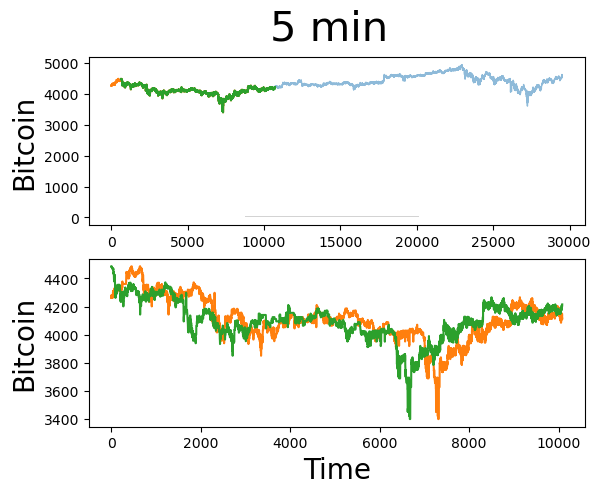

In [16]:
#Наиболее схожие тенденции
i=0
fig, axs = plt.subplots(2)
plt.suptitle(days_df.index[i], fontsize='30')
axs[0].set_ylabel("Bitcoin", fontsize='20')
axs[0].plot(df['close'], alpha=0.5, linewidth=1)
axs[0].plot(df['close'].iloc[motif_idx_ar[i]:motif_idx_ar[i]+varying_m])
axs[0].plot(df['close'].iloc[nearest_neighbor_idx_ar[i]:nearest_neighbor_idx_ar[i]+varying_m])
rect = Rectangle((varying_m, 0), varying_m, 40, facecolor='lightgrey')
axs[0].add_patch(rect)
rect = Rectangle((8724, 0), varying_m, 40, facecolor='lightgrey')
axs[0].add_patch(rect)
axs[1].set_xlabel("Time", fontsize='20')
axs[1].set_ylabel("Bitcoin", fontsize='20')
axs[1].plot(df['close'].values[motif_idx_ar[i]:motif_idx_ar[i]+varying_m], color='C1')
axs[1].plot(df['close'].values[nearest_neighbor_idx_ar[i]:nearest_neighbor_idx_ar[i]+varying_m], color='C2')
plt.show()

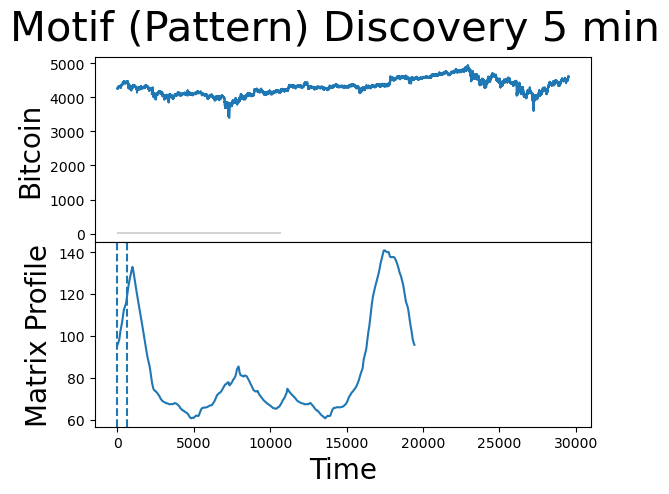

In [17]:
#И вот тут мотив (приблизительно повторяющиеся подпоследовательности, найденные в более длинном временном ряду)

fig, axs = plt.subplots(2, sharex=True, gridspec_kw={'hspace': 0})
plt.suptitle('Motif (Pattern) Discovery '+days_df.index[i], fontsize='30')

axs[0].plot(df['close'].values)
axs[0].set_ylabel('Bitcoin', fontsize='20')
rect = Rectangle((motif_idx_ar[i], 0), varying_m, 40, facecolor='lightgrey')
axs[0].add_patch(rect)
rect = Rectangle((nearest_neighbor_idx_ar[i], 0), varying_m, 40, facecolor='lightgrey')
axs[0].add_patch(rect)
axs[1].set_xlabel('Time', fontsize ='20')
axs[1].set_ylabel('Matrix Profile', fontsize='20')
axs[1].axvline(x=motif_idx_ar[i], linestyle="dashed")
axs[1].axvline(x=nearest_neighbor_idx_ar[i], linestyle="dashed")
axs[1].plot(mp[:, 0])
plt.show()

In [18]:
# Посмотреть что там вообще
mp_dict

{'5 min': array([[0.0, 635, -1, 635],
        [0.0, 1463, -1, 1463],
        [0.0, 98, -1, 98],
        ...,
        [0.023666249517512193, 8564, 8564, -1],
        [0.1127799872689386, 29501, 29501, -1],
        [0.025106947905846347, 19727, 19727, -1]], dtype=object),
 '15 min': array([[0.0, 11784, -1, 11784],
        [0.0, 11785, -1, 11785],
        [0.0, 380, -1, 380],
        ...,
        [1.5305461917101069, 7524, 7524, -1],
        [1.4901535448505943, 7525, 7525, -1],
        [1.2726924365804888, 17843, 17843, -1]], dtype=object),
 '30 min': array([[2.3288096952725534, 6671, -1, 6671],
        [3.499051860825484, 24189, -1, 24189],
        [2.3935448551713514, 26127, -1, 26127],
        ...,
        [1.8427617431496555, 3369, 3369, -1],
        [1.7231012556637166, 217, 217, -1],
        [1.6407667984572398, 218, 218, -1]], dtype=object),
 '1 hour': array([[2.1905614924916907, 13148, -1, 13148],
        [2.1803705806675366, 13149, -1, 13149],
        [2.172587059523124, 13294, 

In [19]:
#Ниже смотрю разные сглаживания

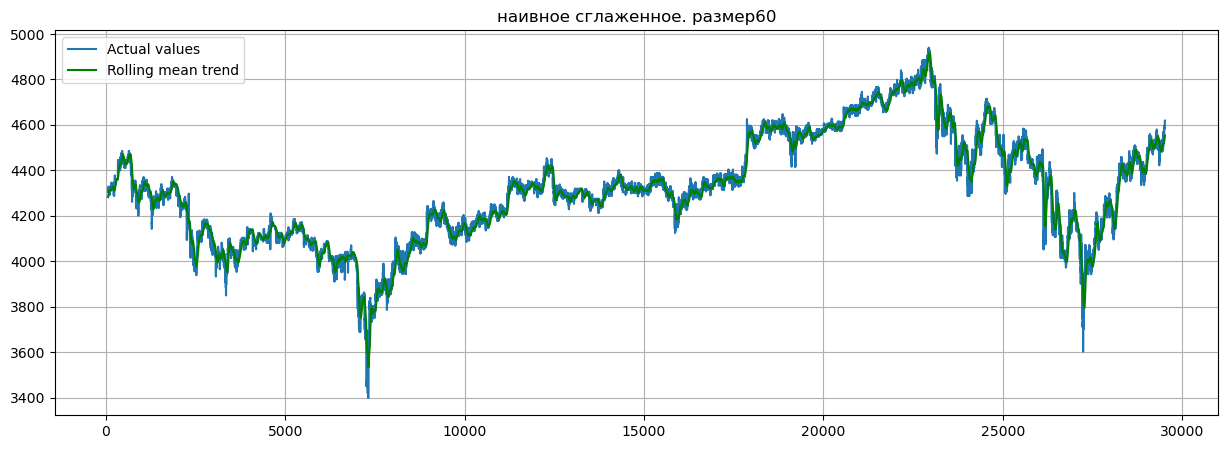

In [20]:
#наивное сглаженное
def plot_an(orig, priv,name=""):
    plt.figure(figsize=(15,5))
    plt.title(name)
    plt.plot(orig, label="Actual values")
    plt.plot(priv, "g", label="Rolling mean trend")

    
    plt.legend(loc="upper left")
    plt.grid(True)

n=60
plot_an(df['close'][n:], df['close'].rolling(window=n).mean(),"наивное сглаженное. размер"+str(n))

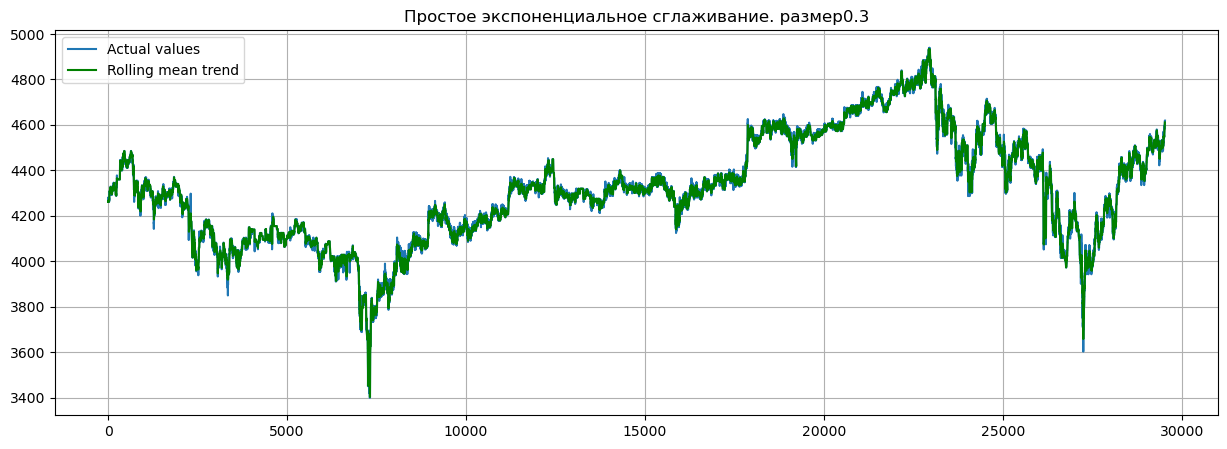

In [21]:
#Простое экспоненциальное сглаживание
def exponential_smoothing(series, alpha):
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result
n=0.3
plot_an(df['close'], exponential_smoothing(df['close'], alpha=n), "Простое экспоненциальное сглаживание. размер"+str(n))

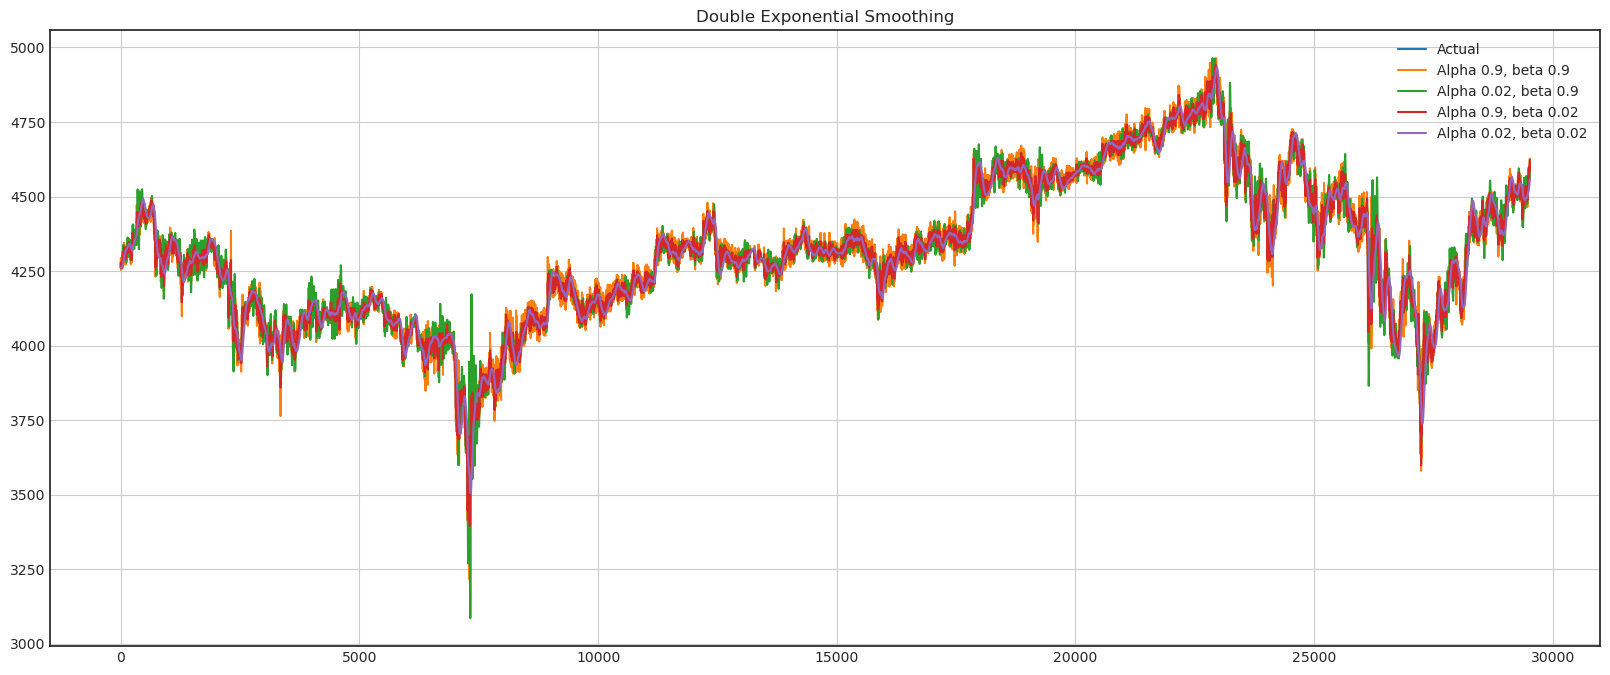

In [22]:
#Двойное экспоненциальное сглаживание

def double_exponential_smoothing(series, alpha, beta):
    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # прогнозируем
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return result


with plt.style.context('seaborn-white'):    
    plt.figure(figsize=(20, 8))
    plt.plot(df['close'], label = "Actual")
    
    for beta in [0.9, 0.02]:
        for alpha in [0.9, 0.02]:
            plt.plot(double_exponential_smoothing(df['close'], alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
    
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Double Exponential Smoothing")
    plt.grid(True)

In [23]:
# Модель Хольта-Винтерса
class HoltWinters:

    """
    Модель Хольта-Винтерса с методом Брутлага для детектирования аномалий
    https://fedcsis.org/proceedings/2012/pliks/118.pdf

    # series - исходный временной ряд
    # slen - длина сезона
    # alpha, beta, gamma - коэффициенты модели Хольта-Винтерса
    # n_preds - горизонт предсказаний
    # scaling_factor - задаёт ширину доверительного интервала по Брутлагу (обычно принимает значения от 2 до 3)

    """

    def __init__(self, series, slen, alpha, beta, gamma, n_preds, scaling_factor=1.96):
        self.series = series
        self.slen = slen
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.n_preds = n_preds
        self.scaling_factor = scaling_factor

    def initial_trend(self):
        sum = 0.0
        for i in range(self.slen):
            sum += float(self.series[i+self.slen] - self.series[i]) / self.slen
        return sum / self.slen  

    def initial_seasonal_components(self):
        seasonals = {}
        season_averages = []
        n_seasons = int(len(self.series)/self.slen)
        # вычисляем сезонные средние
        for j in range(n_seasons):
            season_averages.append(sum(self.series[self.slen*j:self.slen*j+self.slen])/float(self.slen))
        # вычисляем начальные значения
        for i in range(self.slen):
            sum_of_vals_over_avg = 0.0
            for j in range(n_seasons):
                sum_of_vals_over_avg += self.series[self.slen*j+i]-season_averages[j]
            seasonals[i] = sum_of_vals_over_avg/n_seasons
        return seasonals   

    def triple_exponential_smoothing(self):
        self.result = []
        self.Smooth = []
        self.Season = []
        self.Trend = []
        self.PredictedDeviation = []
        self.UpperBond = []
        self.LowerBond = []

        seasonals = self.initial_seasonal_components()

        for i in range(len(self.series)+self.n_preds):
            if i == 0: # инициализируем значения компонент
                smooth = self.series[0]
                trend = self.initial_trend()
                self.result.append(self.series[0])
                self.Smooth.append(smooth)
                self.Trend.append(trend)
                self.Season.append(seasonals[i%self.slen])

                self.PredictedDeviation.append(0)

                self.UpperBond.append(self.result[0] + 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])

                self.LowerBond.append(self.result[0] - 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])

                continue
            if i >= len(self.series): # прогнозируем
                m = i - len(self.series) + 1
                self.result.append((smooth + m*trend) + seasonals[i%self.slen])

                # во время прогноза с каждым шагом увеличиваем неопределенность
                self.PredictedDeviation.append(self.PredictedDeviation[-1]*1.01) 

            else:
                val = self.series[i]
                last_smooth, smooth = smooth, self.alpha*(val-seasonals[i%self.slen]) + (1-self.alpha)*(smooth+trend)
                trend = self.beta * (smooth-last_smooth) + (1-self.beta)*trend
                seasonals[i%self.slen] = self.gamma*(val-smooth) + (1-self.gamma)*seasonals[i%self.slen]
                self.result.append(smooth+trend+seasonals[i%self.slen])

                # Отклонение рассчитывается в соответствии с алгоритмом Брутлага
                self.PredictedDeviation.append(self.gamma * np.abs(self.series[i] - self.result[i]) 
                                               + (1-self.gamma)*self.PredictedDeviation[-1])

            self.UpperBond.append(self.result[-1] + 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.LowerBond.append(self.result[-1] - 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.Smooth.append(smooth)
            self.Trend.append(trend)
            self.Season.append(seasonals[i % self.slen])

In [24]:
#задаем период предсказаний
slend=days_df['m']["5 min"]#["Half-Day"]#["15 min"]
def timeseriesCVscore(x):
    # вектор ошибок
    errors = []

    values = data.values
    alpha, beta, gamma = x

    # задаём число фолдов для кросс-валидации
    tscv = TimeSeriesSplit(n_splits=3) 

    # идем по фолдам, на каждом обучаем модель, строим прогноз на отложенной выборке и считаем ошибку
    for train, test in tqdm(tscv.split(values)):

        model = HoltWinters(series=values[train], slen = slend, alpha=alpha, beta=beta, gamma=gamma, n_preds=len(test))
        model.triple_exponential_smoothing()

        predictions = model.result[-len(test):]
        actual = values[test]
        error = sklearn.metrics.mean_squared_error(predictions, actual)
        errors.append(error)

    # Возвращаем средний квадрат ошибки по вектору ошибок 
    return np.mean(np.array(errors))

In [25]:
#обучаем
dt = pd.Series(double_exponential_smoothing(df['close'], 0.2, 0.2))
data = dt[:-500]
k=128
# инициализируем значения параметров
x = [0, 0, 0] 

# Минимизируем функцию потерь с ограничениями на параметры
opt = minimize(timeseriesCVscore, x0=x, method="TNC", bounds = ((0, 1), (0, 1), (0, 1)))

# Из оптимизатора берем оптимальное значение параметров
alpha_final, beta_final, gamma_final = opt.x
print(alpha_final, beta_final, gamma_final)

# Передаем оптимальные значения модели, 
data = dt 
model = HoltWinters(data[:-k], slen = slend, alpha = alpha_final, beta = beta_final, gamma = gamma_final, n_preds = k, scaling_factor = 2.56)
model.triple_exponential_smoothing()

3it [00:00, 18.40it/s]
3it [00:00, 17.86it/s]
3it [00:00, 18.18it/s]
3it [00:00, 18.29it/s]
3it [00:00, 18.07it/s]
3it [00:00, 18.29it/s]
3it [00:00, 18.07it/s]
3it [00:00, 18.29it/s]
3it [00:00, 18.13it/s]
3it [00:00, 18.29it/s]
3it [00:00, 18.07it/s]
3it [00:00, 16.67it/s]
3it [00:00, 18.07it/s]
3it [00:00, 18.40it/s]
3it [00:00, 18.29it/s]
3it [00:00, 18.29it/s]
3it [00:00, 18.18it/s]
3it [00:00, 17.75it/s]
3it [00:00, 18.07it/s]
3it [00:00, 18.07it/s]
3it [00:00, 17.96it/s]
3it [00:00, 18.18it/s]
3it [00:00, 18.07it/s]
3it [00:00, 18.07it/s]
3it [00:00, 18.18it/s]
3it [00:00, 18.29it/s]
3it [00:00, 18.18it/s]
3it [00:00, 18.25it/s]
3it [00:00, 17.86it/s]
3it [00:00, 18.18it/s]
3it [00:00, 18.18it/s]
3it [00:00, 18.29it/s]
3it [00:00, 18.18it/s]
3it [00:00, 18.18it/s]
3it [00:00, 18.18it/s]
3it [00:00, 18.18it/s]
3it [00:00, 17.75it/s]
3it [00:00, 18.18it/s]
3it [00:00, 18.07it/s]
3it [00:00, 18.07it/s]
3it [00:00, 18.07it/s]
3it [00:00, 18.07it/s]
3it [00:00, 17.85it/s]
3it [00:00,

0.0005099341746084285 8.275942520846735e-05 0.0008715923521249169


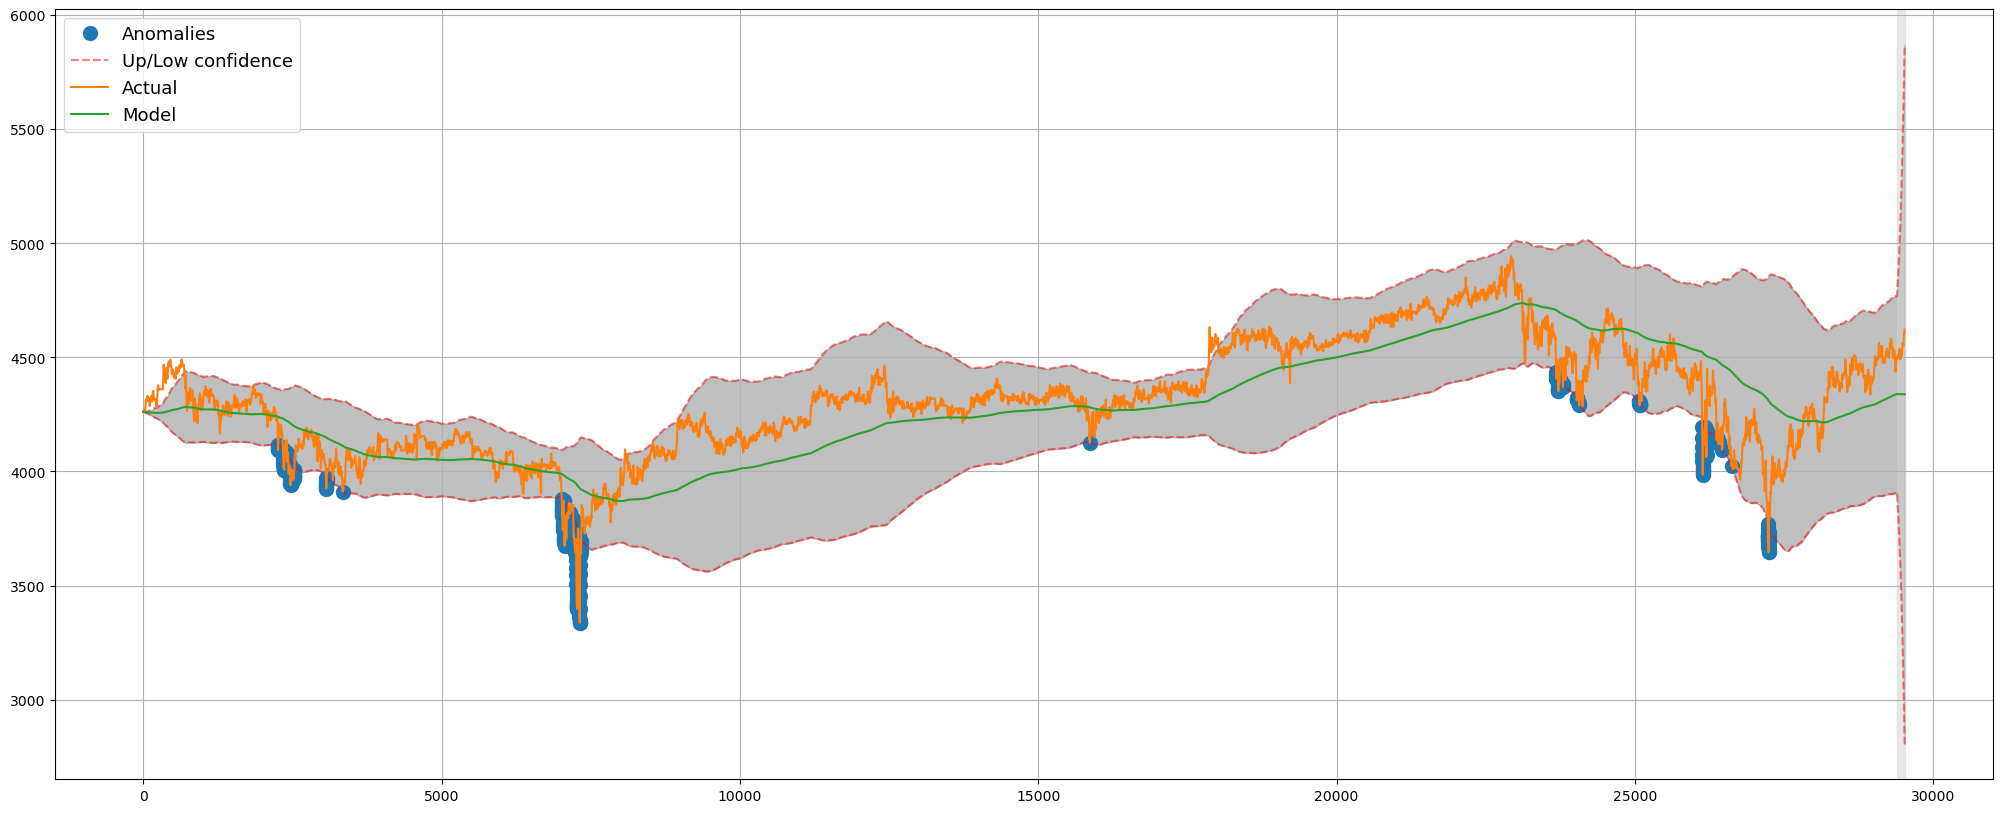

In [26]:
#график
def plotHoltWinters():
    Anomalies = np.array([np.NaN]*len(data))
    Anomalies[data.values<model.LowerBond] = data.values[data.values<model.LowerBond]
    plt.figure(figsize=(25, 10))
    plt.plot(Anomalies, "o", markersize=10, label = "Anomalies")
    plt.plot(model.UpperBond, "r--", alpha=0.5, label = "Up/Low confidence")
    plt.plot(model.LowerBond, "r--", alpha=0.5)
    plt.fill_between(x=range(0,len(model.result)), y1=model.UpperBond, y2=model.LowerBond, alpha=0.5, color = "grey")
    plt.plot(data.values, label = "Actual")
    
    plt.plot(model.result, label = "Model")
    plt.axvspan(len(data)-k, len(data), alpha=0.5, color='lightgrey')
    plt.grid(True)
    plt.axis('tight')
    plt.legend(loc="best", fontsize=13);

plotHoltWinters()

In [27]:
#смотрим итоги, что он тут повыводил (на какую дату-время и что вывел)
pred = model.result[-k:]
dt = df[['close', 'timestamp']][-k:]
for i in range (k):
    print(dt['timestamp'].iloc[i], 'Real:', dt['close'].iloc[i], 'Pred:', pred[i])

2017-09-06 13:52:00 Real: 4490.0 Pred: 4339.476563649738
2017-09-06 13:53:00 Real: 4490.0 Pred: 4339.545536199286
2017-09-06 13:54:00 Real: 4490.0 Pred: 4339.540654982467
2017-09-06 13:55:00 Real: 4490.0 Pred: 4339.605620933798
2017-09-06 13:56:00 Real: 4490.0 Pred: 4339.603041875552
2017-09-06 13:57:00 Real: 4501.35 Pred: 4339.43157648553
2017-09-06 13:58:00 Real: 4490.0 Pred: 4339.5005490350795
2017-09-06 13:59:00 Real: 4502.77 Pred: 4339.495667818259
2017-09-06 14:00:00 Real: 4502.77 Pred: 4339.56063376959
2017-09-06 14:01:00 Real: 4490.01 Pred: 4339.558054711345
2017-09-06 14:02:00 Real: 4502.77 Pred: 4339.386589321322
2017-09-06 14:03:00 Real: 4502.77 Pred: 4339.455561870872
2017-09-06 14:04:00 Real: 4502.77 Pred: 4339.450680654052
2017-09-06 14:05:00 Real: 4502.78 Pred: 4339.515646605382
2017-09-06 14:06:00 Real: 4494.01 Pred: 4339.513067547137
2017-09-06 14:07:00 Real: 4494.01 Pred: 4339.341602157116
2017-09-06 14:08:00 Real: 4495.0 Pred: 4339.410574706664
2017-09-06 14:09:00 Re